In [18]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pymc as pm
import arviz as az

# Set random seed for reproducibility
np.random.seed(42)

# Number of observations
n = 1000

# Generate the running variable
X = np.random.uniform(-1, 1, n)

# Define the cutoff
cutoff = 0

# Generate treatment with some fuzziness
D = (X > cutoff).astype(int) + np.random.normal(0, 0.2, n)

# Simulate the true treatment effect and outcome (Y)
true_effect = 3
noise = np.random.normal(0, 1, n)

# Outcome variable: Y = f(X) + true_effect * D + noise
Y = 1 + 0.5 * X + true_effect * D + noise

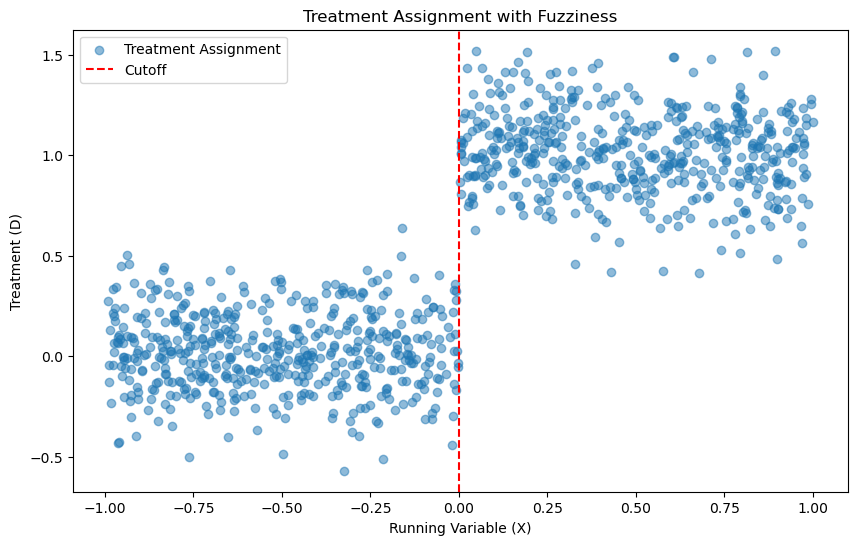

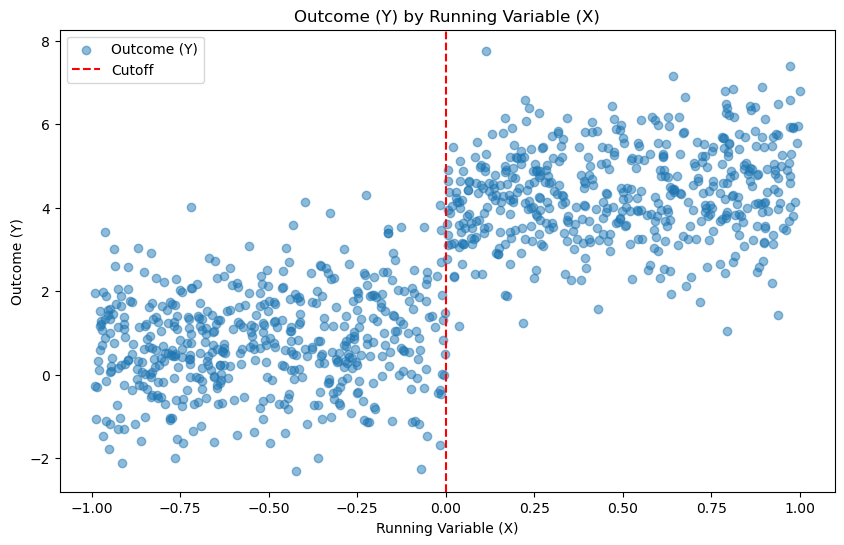

In [19]:
# Visualization of treatment assignment
plt.figure(figsize=(10, 6))
plt.scatter(X, D, alpha=0.5, label="Treatment Assignment")
plt.axvline(cutoff, color="red", linestyle="--", label="Cutoff")
plt.title("Treatment Assignment with Fuzziness")
plt.xlabel("Running Variable (X)")
plt.ylabel("Treatment (D)")
plt.legend()
plt.show()

# Visualization of outcome (Y)
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, label="Outcome (Y)")
plt.axvline(cutoff, color="red", linestyle="--", label="Cutoff")
plt.title("Outcome (Y) by Running Variable (X)")
plt.xlabel("Running Variable (X)")
plt.ylabel("Outcome (Y)")
plt.legend()
plt.show()

In [20]:
X_design = sm.add_constant(np.column_stack((X, (X > cutoff).astype(int))))

In [21]:
with pm.Model() as model:
    # Priors for first stage
    first_stage_betas = pm.Normal("first_stage", mu=0, sigma=10, shape=X_design.shape[1])

    # Likelihood for treatment assignment (first stage)
    D_mean = pm.math.dot(X_design, first_stage_betas)
    sigma_D = pm.HalfNormal("sigma_D", sigma=1)
    D_hat = pm.Normal("D_hat", mu=D_mean, sigma=sigma_D, observed=D)

    # Likelihood for the (second stage)
    second_stage_betas = pm.Normal("second_stage", mu=0, sigma=10, shape=X_design.shape[1])
    sigma_Y = pm.HalfNormal("sigma_Y", sigma=1)

    # Likelihood for outcome (second stage)
    Y_mean = pm.math.dot(sm.add_constant(X), second_stage_betas[:X_design.shape[1]-1]) + D_hat * second_stage_betas[X_design.shape[1]-1]
    Y = pm.Normal("Y", mu=Y_mean, sigma=sigma_Y, observed=Y)

In [22]:
with model:
  idata =  pm.sample(nuts_sampler="nutpie")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.58,7
,2000,0,0.56,7
,2000,0,0.57,11
,2000,0,0.57,7


The main focus here is that simulated parameter values are captured by the model.

In [23]:
az.summary(idata, var_names= [ "second_stage"], hdi_prob=.99)

,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
second_stage[0],1.085,0.058,0.940,1.237,0.001,0.001,1788.0,2206.0,1.0
second_stage[1],0.709,0.087,0.486,0.936,0.002,0.001,2016.0,2351.0,1.0
second_stage[2],2.872,0.094,2.624,3.098,0.002,0.002,1697.0,1996.0,1.0


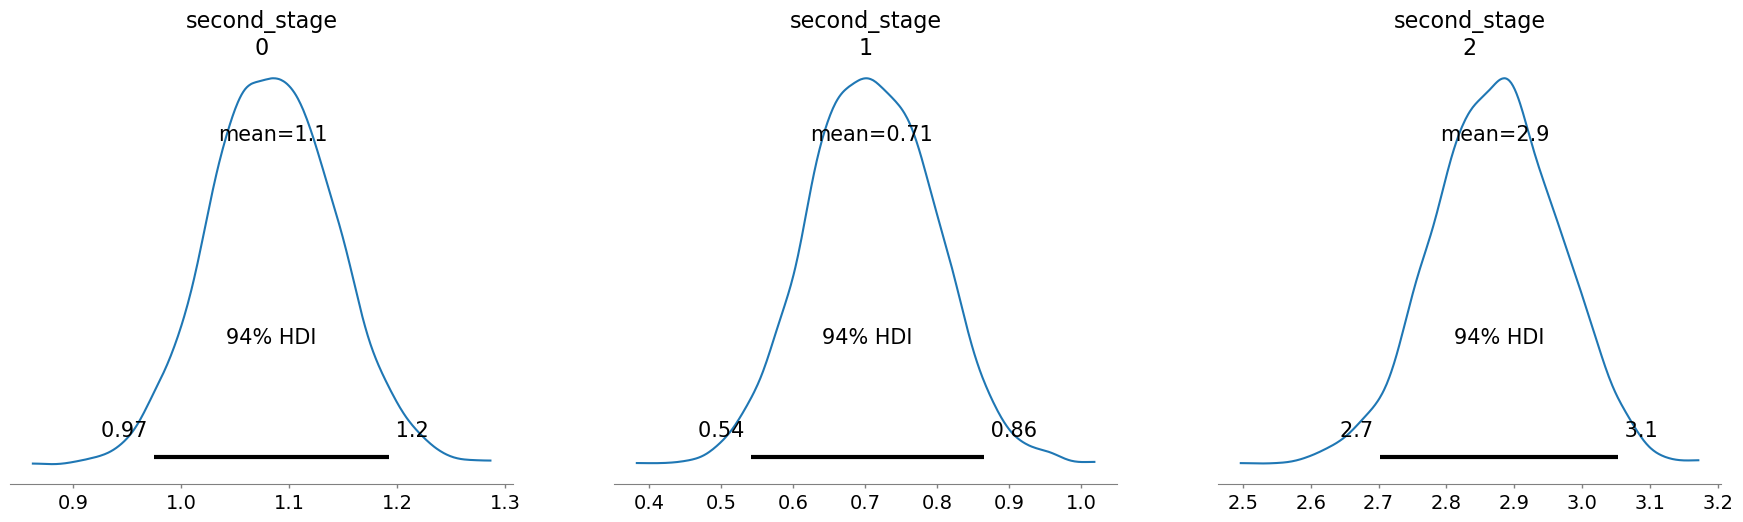

In [24]:
az.plot_posterior(idata, var_names="second_stage");